<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow_addons

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds
from tensorflow_addons.layers import InstanceNormalization

import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
_URL = 'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

In [4]:
image_shape = (256, 256, 3)
IMG_HEIGHT = image_shape[0]
IMG_WIDTH = image_shape[1]

In [5]:
BATCH_SIZE = 1
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset, ds_info = tfds.load('cycle_gan/horse2zebra', with_info=True,  as_supervised=True)
train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

def random_crop(image):
    cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image, label):
    image = normalize(image)
    return image

train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1).repeat()

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1).repeat()

train_dataset = tf.data.Dataset.zip((train_horses, train_zebras))
test_dataset = tf.data.Dataset.zip((test_horses, test_zebras))

In [6]:
def downsample(channels, kernels, strides=2, norm=True, activation=True, dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                            use_bias=False, kernel_initializer=initializer))

    if norm:
        block.add(InstanceNormalization())              
    if activation:
        block.add(layers.LeakyReLU(0.2)) 
    if dropout:
        block.add(layers.Dropout(0.5))

    return block

def upsample(channels, kernels, strides=1, norm=True, activation=True, dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.UpSampling2D((2,2)))
    block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

    if norm:
        block.add(InstanceNormalization())              
    if activation:
        block.add(layers.LeakyReLU(0.2)) 
    if dropout:
        block.add(layers.Dropout(0.5))

    return block

In [7]:
def build_generator():

    DIM = 64

    input_image = layers.Input(shape=image_shape)
    down1 = downsample(DIM, 4, norm=False)(input_image) # 128, DIM
    down2 = downsample(2*DIM, 4)(down1) # 64, 2*DIM
    down3 = downsample(4*DIM, 4)(down2) # 32, 4*DIM
    down4 = downsample(4*DIM, 4)(down3) # 16, 4*DIM
    down5 = downsample(4*DIM, 4)(down4) # 8, 4*DIM
    down6 = downsample(4*DIM, 4)(down5) # 4, 4*DIM
    down7 = downsample(4*DIM, 4)(down6) # 2, 4*DIM


    up6 = upsample(4*DIM, 4, dropout=True)(down7) # 4,4*DIM
    concat6 = layers.Concatenate()([up6, down6])   

    up5 = upsample(4*DIM, 4, dropout=True)(concat6) 
    concat5 = layers.Concatenate()([up5, down5]) 

    up4 = upsample(4*DIM, 4, dropout=True)(concat5) 
    concat4 = layers.Concatenate()([up4, down4]) 

    up3 = upsample(4*DIM, 4)(concat4) 
    concat3 = layers.Concatenate()([up3, down3]) 

    up2 = upsample(2*DIM, 4)(concat3) 
    concat2 = layers.Concatenate()([up2, down2]) 

    up1 = upsample(DIM, 4)(concat2) 
    concat1 = layers.Concatenate()([up1, down1]) 

    output_image = tanh(upsample(3, 4, norm=False, activation=False)(concat1))

    return Model(input_image, output_image)  

In [8]:
def build_discriminator():
    DIM = 64
    input_image = layers.Input(shape=image_shape)

    x = downsample(DIM, 4, norm=False)(input_image) # 128
    x = downsample(2*DIM, 4)(x) # 64
    x = downsample(4*DIM, 4)(x) # 32
    x = downsample(8*DIM, 4, strides=1)(x) # 29
    output = layers.Conv2D(1, 4)(x)

    return Model(input_image, output) 

In [9]:
class CycleGAN(Model):

    def __init__(self, image_shape):
        super(CycleGAN, self).__init__()

        self.image_shape = image_shape

        self.disc_a = build_discriminator()
        self.disc_b = build_discriminator()

        self.gen_ab = build_generator()
        self.gen_ba = build_generator()

        disc_output = self.disc_b(self.gen_ab.output)

        self.patch_size = disc_output.shape[1]

        self.LAMBDA = 10
        self.LAMBDA_ID = 2
    
    def compile(self, d_optimizer, g_optimizer,
                recon_loss_fn = tf.keras.losses.mean_absolute_error,
                adv_loss_fn=tf.keras.losses.mean_squared_error):
        
        super(CycleGAN, self).compile()

        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.recon_loss_fn = recon_loss_fn
        self.adv_loss_fn = adv_loss_fn
    
    def train_step(self, inputs):
        real_images_A, real_images_B = inputs

        batch_size = tf.shape(real_images_A)[0]

        real_labels = tf.ones((batch_size, self.patch_size, self.patch_size, 1))
        fake_labels = tf.zeros((batch_size, self.patch_size, self.patch_size, 1))

        with tf.GradientTape() as d_tape, \
            tf.GradientTape() as g_tape:

            fake_images_B = self.gen_ab(real_images_A)
            fake_images_A = self.gen_ba(real_images_B)

            fake_preds_A = self.disc_a(fake_images_A)
            fake_preds_B = self.disc_b(fake_images_B)

            real_preds_A = self.disc_a(real_images_A)
            real_preds_B = self.disc_b(real_images_B)

            fake_loss = self.adv_loss_fn(fake_labels, fake_preds_A) + self.adv_loss_fn(fake_labels, fake_preds_B)
            real_loss = self.adv_loss_fn(real_labels, real_preds_A) + self.adv_loss_fn(real_labels, real_preds_B)
            d_loss = 0.5 * (fake_loss + real_loss)

            g_adv_loss =tf.reduce_mean(self.adv_loss_fn(real_labels, fake_preds_A) + self.adv_loss_fn(real_labels, fake_preds_B), axis=[0, 1, 2])

            cycle_fake_images_A = self.gen_ba(fake_images_B)
            cycle_fake_images_B = self.gen_ab(fake_images_A)

            g_cycle_cons_loss = tf.reduce_mean(self.recon_loss_fn(cycle_fake_images_A, real_images_A) + self.recon_loss_fn(cycle_fake_images_B, real_images_B), axis=[0, 1, 2])

            g_identity_loss = tf.reduce_mean(self.recon_loss_fn(real_images_A, fake_images_B) + self.recon_loss_fn(real_images_B, fake_images_A), axis=[0, 1, 2])

            g_loss = (self.LAMBDA * g_cycle_cons_loss + self.LAMBDA_ID * g_identity_loss + g_adv_loss) / (self.LAMBDA + self.LAMBDA_ID + 1)

        gen_vars = self.gen_ab.trainable_variables + self.gen_ba.trainable_variables
        disc_vars = self.disc_a.trainable_variables + self.disc_b.trainable_variables

        g_grads = g_tape.gradient(g_loss, gen_vars)
        d_grads = d_tape.gradient(d_loss, disc_vars)

        self.g_optimizer.apply_gradients(zip(g_grads, gen_vars))
        self.d_optimizer.apply_gradients(zip(d_grads, disc_vars))

        return {'g_cycle_cons_loss': g_cycle_cons_loss, 
                'g_adv_loss': g_adv_loss,
                'd_loss': d_loss}
        
    def call(self, inputs, dir='AB'):
        if dir == 'AB':
            return self.gen_ab(inputs)
        return self.gen_ba(inputs)

In [10]:
class GenerativeCallback(tf.keras.callbacks.Callback):

    def __init__(self, test_dataset, num_imgs=4, interval=5):
        super(GenerativeCallback, self).__init__()
        
        self.num_imgs = num_imgs
        self.interval = interval
        self.ds = iter(test_dataset)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch % self.interval) is not 0:
            return 

        grid_row = 1
        grid_col = self.num_imgs

        batch_A, batch_B = next(self.ds)
        images_A = self.model(batch_A, dir='AB')
        images_B = self.model(batch_B, dir='BA')

        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))

        for col in range(grid_col):
            axarr[col].axis('off') 

        axarr[0].imshow((batch_A[0] + 1)/2)
        axarr[1].imshow((images_A[0] + 1)/2)
        axarr[2].imshow((batch_B[0] + 1)/2)
        axarr[3].imshow((images_B[0] + 1)/2)
        
        plt.show()

Epoch 1/30
1067/1067 [==============================] - 306s 265ms/step - g_cycle_cons_loss: 0.2571 - g_adv_loss: 0.7552 - d_loss: 0.6243


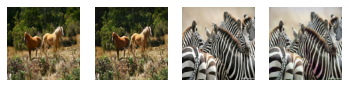

Epoch 2/30
1067/1067 [==============================] - 284s 266ms/step - g_cycle_cons_loss: 0.1781 - g_adv_loss: 0.7758 - d_loss: 0.5060


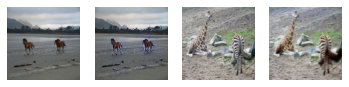

Epoch 3/30
1067/1067 [==============================] - 284s 266ms/step - g_cycle_cons_loss: 0.1599 - g_adv_loss: 0.8210 - d_loss: 0.4850


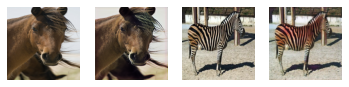

Epoch 4/30
1067/1067 [==============================] - 285s 267ms/step - g_cycle_cons_loss: 0.1499 - g_adv_loss: 0.8732 - d_loss: 0.4600


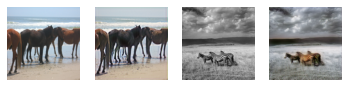

Epoch 5/30
1067/1067 [==============================] - 285s 267ms/step - g_cycle_cons_loss: 0.1489 - g_adv_loss: 0.9136 - d_loss: 0.4441


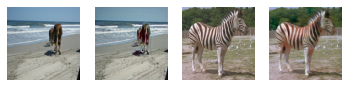

Epoch 6/30
1067/1067 [==============================] - 285s 267ms/step - g_cycle_cons_loss: 0.1471 - g_adv_loss: 0.9278 - d_loss: 0.4227


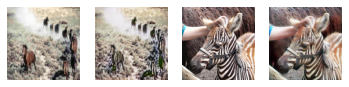

Epoch 7/30
1067/1067 [==============================] - 286s 268ms/step - g_cycle_cons_loss: 0.1440 - g_adv_loss: 0.9505 - d_loss: 0.4091


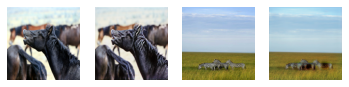

Epoch 8/30
1067/1067 [==============================] - 286s 268ms/step - g_cycle_cons_loss: 0.1448 - g_adv_loss: 0.9923 - d_loss: 0.3851


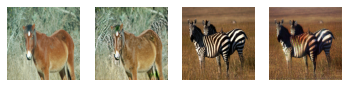

Epoch 9/30
1067/1067 [==============================] - 287s 268ms/step - g_cycle_cons_loss: 0.1450 - g_adv_loss: 1.0014 - d_loss: 0.3830


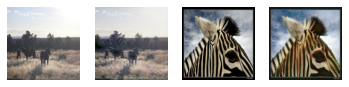

Epoch 10/30
1067/1067 [==============================] - 287s 269ms/step - g_cycle_cons_loss: 0.1436 - g_adv_loss: 0.9986 - d_loss: 0.3747


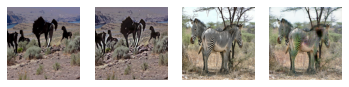

Epoch 11/30
1067/1067 [==============================] - 287s 269ms/step - g_cycle_cons_loss: 0.1420 - g_adv_loss: 0.9952 - d_loss: 0.3728


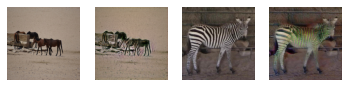

Epoch 12/30
1067/1067 [==============================] - 287s 269ms/step - g_cycle_cons_loss: 0.1419 - g_adv_loss: 1.0132 - d_loss: 0.3615


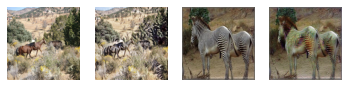

Epoch 13/30
1067/1067 [==============================] - 288s 270ms/step - g_cycle_cons_loss: 0.1398 - g_adv_loss: 1.0122 - d_loss: 0.3565


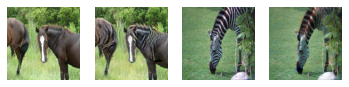

Epoch 14/30
1067/1067 [==============================] - 288s 270ms/step - g_cycle_cons_loss: 0.1406 - g_adv_loss: 1.0302 - d_loss: 0.3472


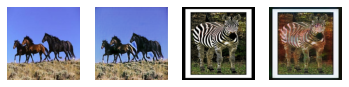

Epoch 15/30
1067/1067 [==============================] - 289s 271ms/step - g_cycle_cons_loss: 0.1403 - g_adv_loss: 1.0404 - d_loss: 0.3468


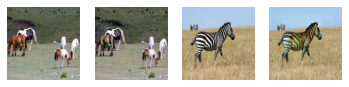

Epoch 16/30
1067/1067 [==============================] - 289s 271ms/step - g_cycle_cons_loss: 0.1391 - g_adv_loss: 1.0509 - d_loss: 0.3378


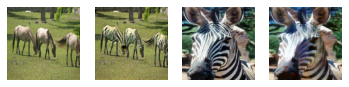

Epoch 17/30
1067/1067 [==============================] - 289s 271ms/step - g_cycle_cons_loss: 0.1386 - g_adv_loss: 1.0503 - d_loss: 0.3359


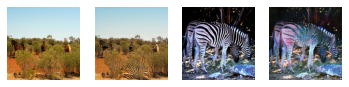

Epoch 18/30
1067/1067 [==============================] - 289s 271ms/step - g_cycle_cons_loss: 0.1379 - g_adv_loss: 1.0544 - d_loss: 0.3327


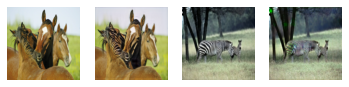

Epoch 19/30
1067/1067 [==============================] - 289s 271ms/step - g_cycle_cons_loss: 0.1378 - g_adv_loss: 1.0646 - d_loss: 0.3261


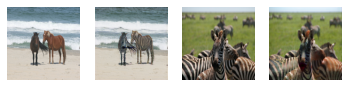

Epoch 20/30
1067/1067 [==============================] - 290s 271ms/step - g_cycle_cons_loss: 0.1378 - g_adv_loss: 1.0947 - d_loss: 0.3167


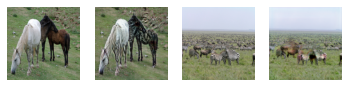

Epoch 21/30
1067/1067 [==============================] - 290s 271ms/step - g_cycle_cons_loss: 0.1400 - g_adv_loss: 1.1107 - d_loss: 0.3101


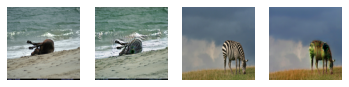

Epoch 22/30
1067/1067 [==============================] - 290s 272ms/step - g_cycle_cons_loss: 0.1387 - g_adv_loss: 1.1125 - d_loss: 0.3072


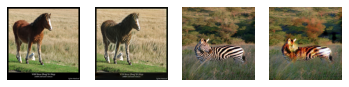

Epoch 23/30
1067/1067 [==============================] - 290s 271ms/step - g_cycle_cons_loss: 0.1395 - g_adv_loss: 1.1316 - d_loss: 0.3044


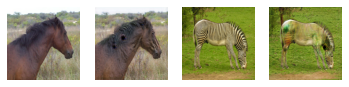

Epoch 24/30
1067/1067 [==============================] - 290s 271ms/step - g_cycle_cons_loss: 0.1382 - g_adv_loss: 1.1356 - d_loss: 0.2988


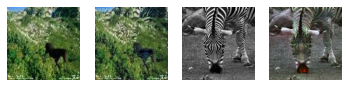

Epoch 25/30
1067/1067 [==============================] - 290s 272ms/step - g_cycle_cons_loss: 0.1390 - g_adv_loss: 1.1571 - d_loss: 0.2920


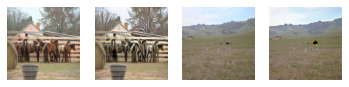

Epoch 26/30
1067/1067 [==============================] - 290s 272ms/step - g_cycle_cons_loss: 0.1402 - g_adv_loss: 1.1779 - d_loss: 0.2873


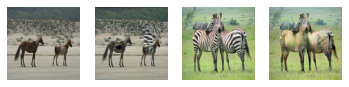

Epoch 27/30
1067/1067 [==============================] - 290s 272ms/step - g_cycle_cons_loss: 0.1381 - g_adv_loss: 1.1637 - d_loss: 0.2868


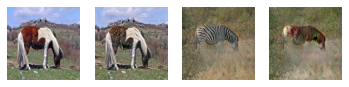

Epoch 28/30
1067/1067 [==============================] - 290s 272ms/step - g_cycle_cons_loss: 0.1399 - g_adv_loss: 1.1959 - d_loss: 0.2785


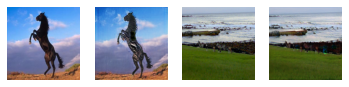

Epoch 29/30
1067/1067 [==============================] - 290s 272ms/step - g_cycle_cons_loss: 0.1396 - g_adv_loss: 1.2013 - d_loss: 0.2749


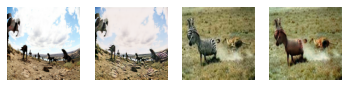

Epoch 30/30
1067/1067 [==============================] - 290s 272ms/step - g_cycle_cons_loss: 0.1398 - g_adv_loss: 1.2199 - d_loss: 0.2671


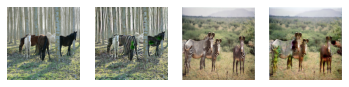

In [11]:
g_optimizer, d_optimizer = Adam(2e-4, 0.5), Adam(2e-4, 0.5)

cycleGAN = CycleGAN(image_shape)
cycleGAN.compile(g_optimizer, d_optimizer)

callbacks = [GenerativeCallback(test_dataset, interval=1)]

cycleGAN.fit(train_dataset, epochs=30, callbacks=callbacks)